In [1]:
import pandas as pd
from ggplot import *
from sklearn.model_selection import KFold
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

C:\Users\xinyu\Anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\Users\xinyu\Anaconda3\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
C:\Users\xinyu\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
drink = pd.read_csv('strongdrink.txt')
drink.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


# (a) Scatter Plot

In [3]:
drink['Cultivar'] = drink['cultivar'].astype(str)

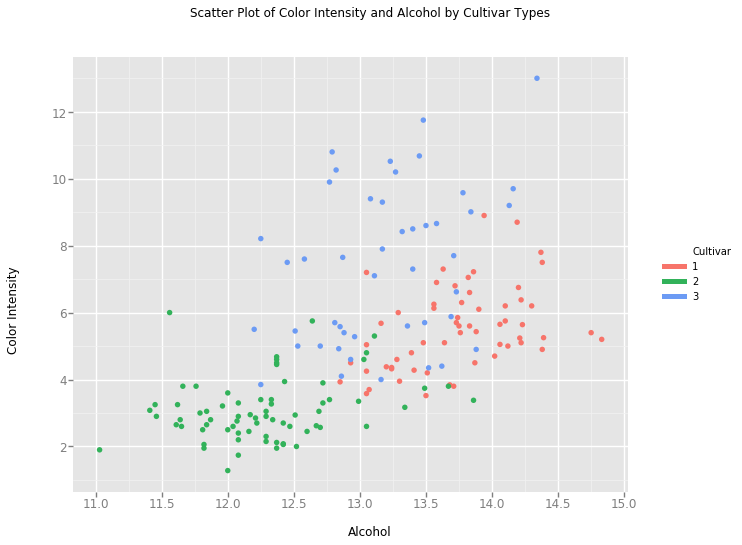

<ggplot: (124526312975)>

In [4]:
ggplot(aes(x='alco', y='color_int', color = 'Cultivar'), data=drink) +\
    geom_point(size = 30) +\
    labs(title = 'Scatter Plot of Color Intensity and Alcohol by Cultivar Types',
        x = 'Alcohol',
        y = 'Color Intensity')

In [5]:
Xvars = drink[['alco', 'malic', 'tot_phen', 'color_int']].values
yvals = drink['cultivar'].values

# (b) Logistic Regression

In [6]:
k = 4
clf_mlog = KFold(n_splits=k, shuffle=True, random_state=22)
clf_mlog.get_n_splits(Xvars)
MSE = np.zeros(k)
C = np.zeros(200)
MSE_C = np.zeros(200)

In [7]:
for index in range(200):
    c = (index + 1)/ 100 
    C[index] = c
    k_ind = 0
    for train_index, test_index in clf_mlog.split(Xvars):
        X_train, X_test = Xvars[train_index], Xvars[test_index]
        y_train, y_test = yvals[train_index], yvals[test_index]
        LogReg = LogisticRegression(multi_class='multinomial', fit_intercept = True,
                                    solver='newton-cg', C = c)
        LogReg.fit(X_train, y_train)
        y_pred = LogReg.predict(X_test)
        error = y_test != y_pred
        MSE[k_ind] = error.mean()
        k_ind += 1
    MSE_C[index] = MSE.mean()
MSE_logit = pd.DataFrame({'C':C, 'MSE':MSE_C})  

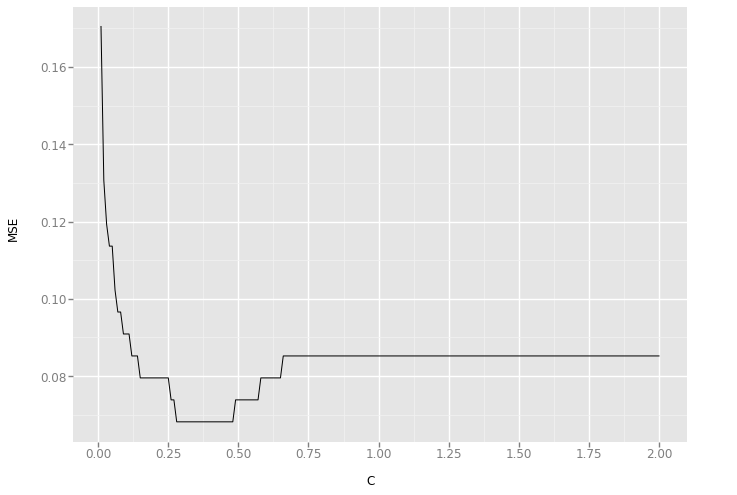

<ggplot: (-9223371912328372939)>

In [8]:
ggplot(aes(x='C', y='MSE'), data=MSE_logit) + geom_line()

In [9]:
MSE_logit.sort_values(['MSE']).head(1)

,C,MSE
43,0.44,0.068182


__The smallest MSE is at C =0.44, and get the lowest MSE around 0.068182(Because in sklearn we only use "l2" penalty when we deal with multinomial, thus we could only play with C)__

# c) Random Forest

__the maximal depth take value from 1 to 9, with an increment of 1__
<br>
__In the loop, the number of estimator range from 20-100, with increment of 20__ 
<br>
__the min_sample_leaft take from 5 to 25 with increment of 5__

In [10]:
MSE_LOOP = pd.DataFrame({"min_samples_leaf" : np.zeros(5),
                         "max_depth" : np.zeros(5),
                         "n_estimator" : np.zeros(5),
                         "MSE" : np.zeros(5)})
MSE_RF = MSE_LOOP[:0]
for msl in range(5):
    for md in range(9):
        for n_est in range(5):
            n_est_temp = n_est * 20 + 20
            msl_temp = msl * 5 + 5
            md_temp = md + 1
            RF = RandomForestClassifier(n_estimators = n_est_temp,
                                        min_samples_leaf = msl_temp,
                                        max_depth = md_temp, bootstrap=True, 
                                        oob_score=True, random_state=22)
            RF.fit(Xvars, yvals)
            MSE_LOOP["n_estimator"][n_est] = n_est_temp
            MSE_LOOP["max_depth"][n_est] = md_temp
            MSE_LOOP["min_samples_leaf"][n_est] = msl_temp
            MSE_LOOP["MSE"][n_est] = 1 - RF.oob_score_
        MSE_RF = pd.concat([MSE_RF, MSE_LOOP])

In [11]:
MSE_RF.index = range(len(MSE_RF))
MSE_RF.sort_values(['MSE']).head(10)

,MSE,max_depth,min_samples_leaf,n_estimator
79,0.068182,7.0,10.0,100.0
58,0.068182,3.0,10.0,80.0
59,0.068182,3.0,10.0,100.0
89,0.068182,9.0,10.0,100.0
69,0.068182,5.0,10.0,100.0
84,0.068182,8.0,10.0,100.0
64,0.068182,4.0,10.0,100.0
74,0.068182,6.0,10.0,100.0
7,0.079545,2.0,5.0,60.0
38,0.079545,8.0,5.0,80.0


__When max_depth =7, and min_samples_leaft = 10, n_estimator = 100, we achieve the lowest MSE of 0.068182__

# (d) Supporting Vector Machine

In [12]:
k = 4
clf_svm = KFold(n_splits=k, random_state=22, shuffle=True)
clf_svm.get_n_splits(Xvars)
MSE = np.zeros(k)
MSE_C = pd.DataFrame({"Cost" : np.zeros(60),
                      "Gamma" : np.zeros(60),
                      "MSE" : np.zeros(60)})
MSE_SVM = MSE_C[:0]

for g in range(60):
    for c in range(60):
        k_ind = int(0)
        for train_index, test_index in clf_svm.split(Xvars):
            X_train, X_test = Xvars[train_index], Xvars[test_index]
            y_train, y_test = yvals[train_index], yvals[test_index]
            svc = svm.SVC(kernel='rbf', gamma = (g/20 + 0.05),
                          C=c/20 + 0.05)
            svc.fit(X_train, y_train)
            y_pred = svc.predict(X_test)
            error = y_test != y_pred
            MSE[k_ind] = error.mean()
            k_ind += 1
        MSE_C['Cost'][c] = c/20 + 0.05
        MSE_C['Gamma'][c] = g/20 + 0.05
        MSE_C['MSE'][c] =  MSE.mean()
    MSE_SVM = pd.concat([MSE_SVM, MSE_C])

In [13]:
MSE_SVM.index = range(len(MSE_SVM))
MSE_SVM.sort_values(['MSE']).head()

,Cost,Gamma,MSE
1998,0.95,1.70,0.045455
1938,0.95,1.65,0.045455
1999,1.00,1.70,0.045455
177,2.90,0.15,0.051136
178,2.95,0.15,0.051136


__when cost = 0.95, Gamma = 1.7, we acheive the lowest MSE of 0.045455__

# (e) Neural Network

__In the for loop, the hidden_layer_size ranges from 50 to 400 with the interval of 50__ 
<br>
__the alpha ranges from 0.05 to 1 with the interval of 0.1__
<br>
__the activations are among the method of 'identity', 'logistic', 'tanh' and 'relu'__

In [14]:
k = 4
clf_svm = KFold(n_splits=k, random_state=22, shuffle=True)
clf_svm.get_n_splits(Xvars)
MSE = np.zeros(k)
activ = np.array(['identity', 'logistic', 'tanh', 'relu'])
MSE_al = pd.DataFrame({"activation" : np.zeros(10),
                       "hidden layer" : np.zeros(10),
                       "alpha" : np.zeros(10),
                       "MSE":np.zeros(10)})
MSE_mlp = MSE_al[:0]

In [15]:
for ac in range(4):
    for h in range(8):
        for al in range(10):
            k_ind = int(0)
            for train_index, test_index in clf_svm.split(Xvars):
                X_train, X_test = Xvars[train_index], Xvars[test_index]
                y_train, y_test = yvals[train_index], yvals[test_index]
                mlp = MLPClassifier(activation=activ[ac], solver='lbfgs',
                                    alpha=(al/10 + 0.05), random_state=25,
                                    hidden_layer_sizes = ((50 * (h + 1)),))
                mlp.fit(X_train, y_train)
                y_pred = mlp.predict(X_test)
                error = y_test != y_pred
                MSE[k_ind] = error.mean()
                k_ind += 1
            MSE_al['activation'][al] = activ[ac]
            MSE_al['hidden layer'][al] = 50 * (h + 1)
            MSE_al['alpha'][al] = al/10 + 0.05
            MSE_al['MSE'][al] =  MSE.mean()
        MSE_mlp = pd.concat([MSE_mlp, MSE_al])

C:\Users\xinyu\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\xinyu\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\xinyu\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\xinyu\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [16]:
MSE_mlp.index = range(len(MSE_mlp))
MSE_mlp.sort_values(['MSE']).head(5)

,MSE,activation,alpha,hidden layer
292,0.039773,relu,0.25,300.0
284,0.039773,relu,0.45,250.0
281,0.045455,relu,0.15,250.0
300,0.045455,relu,0.05,350.0
308,0.045455,relu,0.85,350.0


__When activation is 'relu", alpha is 0.25, hidden layer =300, we have lowest MSE of 0.039773__

# (f) Comparison

In [17]:
n = 10
best_logit = np.array(MSE_logit.sort_values(['MSE']).head(n)['MSE'])
best_RF = np.array(MSE_RF.sort_values(['MSE']).head(n)['MSE'])
best_SVM = np.array(MSE_SVM.sort_values(['MSE']).head(n)['MSE'])
best_mlp = np.array(MSE_mlp.sort_values(['MSE']).head(n)['MSE'])
rank = np.array(range(n)) + 1

Com = pd.DataFrame({'Logit':best_logit, 
                    'RF':best_RF,
                    'SVM':best_SVM,
                    'MLP':best_mlp,
                    'rank':rank})

Text(0,0.5,'Error Rate/MSE')

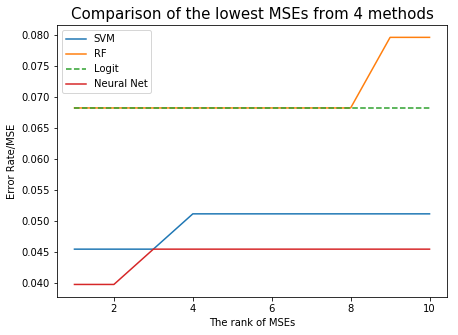

In [18]:
plt.figure(figsize=(7,5))
plt.plot(Com['rank'], Com['SVM'], label='SVM')
plt.plot(Com['rank'], Com['RF'], label='RF')
plt.plot(Com['rank'], Com['Logit'], label='Logit', ls =  'dashed')
plt.plot(Com['rank'], Com['MLP'], label='Neural Net')
plt.legend(loc='best')
plt.title('Comparison of the lowest MSEs from 4 methods', fontsize = 15)
plt.xlabel('The rank of MSEs')
plt.ylabel("Error Rate/MSE")

__The MLP neural network has the best performance in general, this might due to the reason we fitted a lot of model here__